## Homework 1
### Author: Hang Chen

This jupyter notebook is to show the solution of the homework 1 for the class Snow Hydrology: Focus on Modeling. I will use this notebook to answer the question point to point.

## Question 1

Homework_1_D_exercise_2.ipynb walks you through how to run SUMMA for the Umpqua forested site and how to modify the meteorological forcing file to either used observed incoming longwave radiation or an estimate of longwave radiation. It demonstrates the Anderson empirical longwave formulation. Choose two other longwave parameterizations from those listed (Prata, TVA, Satterlund, Dokia), update the meteorological forcing file, and rerun SUMMA.

a. Plot the timeseries of incoming longwave radiation from the original(observed), Anderson, and your two chosen parameterizations (foursimulations total). Calculate the mean value of each and note howthose differ from each other (specifically, what is the mean value ofincoming longwave radiation for each method compared to the meanvalue of the observations).

In [1]:
# begin the assigment and credit homework_1_D.ipynb

%matplotlib inline
import matplotlib.pyplot as plt # if you want to do some plotting using matplotlib (optional)
import numpy as np # provide some mathematical functions
import xarray as xr # read, write, manipulate and analyze NetCDF files
from pathlib import Path
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
import pysumma as ps


## --------function for different longwave radiation calculaiton ----------  ##

# Stephan-Boltzmann constant (J/s/m^2/K^4)
STEFAN = 5.67e-8


def vapor_pressure(air_pressure, spec_humid):
    """See above for derivation"""
    return -1.607 * air_pressure * spec_humid / (spec_humid - 1)


def longwave_prata(air_temp, vapor_pressure):
    """
    Reference:
        Prata, A.J., 1996. A new long-wave formula for estimating
        downward clear-sky radiation at the surface. Q. J. R. Meteor.
        Soc. 122 (533), 1127–1151, doi:10.1002/qj.49712253306.
    """
    z = 46.5 * (vapor_pressure / air_temp)
    emissivity = 1 - (1 + z) * np.exp(-np.sqrt(1.2 + 3 * z))
    return emissivity * np.power(air_temp, 4) * STEFAN
        
    
def longwave_tva(air_temp, vapor_pressure):
    """
    Reference:
        Tennessee Valley Authority, 1972. Heat and mass transfer between a
        water surface and the atmosphere. Tennessee Valley Authority, Norris,
        TN. Laboratory report no. 14. Water resources research report no. 0-6803.
    """
    emissivity = 0.74 + 0.0049 * vapor_pressure/10
    return emissivity * np.power(air_temp, 4) * STEFAN


def longwave_satterlund(air_temp, vapor_pressure):
    """
    Reference:
        Satterlund, D.R., 1979. An improved equation for estimating long-wave
        radiation from the atmosphere. Water Resour. Res. 15 (6), 1649–1650,
        doi:10.1029/WR015i006p01649.
    """
    vp = vapor_pressure / 10
    emissivity = 1.08 * (1 - np.exp(-np.power(vp, air_temp/2016)))
    return emissivity * np.power(air_temp, 4) * STEFAN


def longwave_anderson(air_temp, vapor_pressure):
    """
    Referencce:
        Anderson, E.R., 1954. Energy budget studies, water loss
        investigations: lake Hefner studies. U.S. Geol. Surv. Prof. Pap. 269,
        71–119 [Available from U.S. Geological Survey, 807 National Center,
        Reston, VA 20192.].
    """
    emissivity = 0.68 + 0.036 * np.power(vapor_pressure/10, 0.5)
    return emissivity * np.power(air_temp, 4) * STEFAN


def cloud_correction(shortwave, lat=43.03, highlimit=0.6, lowlimit=0.35):
    """Converted from cloudfactor_Jessica.m"""
    doy = shortwave.time.dt.dayofyear
    s0 = 1360                     # Solar constant (W/m^2)
    phi = lat * 2 * np.pi / 365   # Convert to radian
    # Declination in radians
    delta = (2 * np.pi / 365) * (23.45 * np.sin(2 * np.pi * (284 + doy) / 365))
    
    # Top of atmosphere radiation
    hs = np.arccos(-np.tan(phi) * np.tan(delta))
    q0 = s0 * (1/np.pi) * (
        hs * np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.sin(hs))
    
    # Fraction of recieved radiation
    k = shortwave / q0
    
    # Cloud cover fraction
    cloud_frac = 1 - ((k - lowlimit) / (highlimit - lowlimit))
    cloud_frac = cloud_frac.where(cloud_frac > 0, other=0.0)
    cloud_frac = cloud_frac.where(cloud_frac < 1, other=1.0)
    return cloud_frac
    
    
def longwave_dokia(air_temp, vapor_pressure, shortwave):
    """
    References:
      -Clear sky:
        Dilley, A. C., and D. M. O<92>Brien (1998), Estimating downward clear sky
        long-wave irradiance at the surface from screen temperature and precipitable
        water, Q. J. R. Meteorol. Soc., 124, 1391<96> 1401.
      -Cloudy sky:
        Kimball, B. A., S. B. Idso, and J. K. Aase (1982), A model of thermal                                                                                          
        radiation from partly cloudy and overcast skies, Water Resour. Res., 18,                                                                                       
        931<96> 936.                                   
    """
    vp = vapor_pressure / 1000 # Convert to kPa
    w = 4560 * (vp / air_temp) # Prata (1996) approximation for precipitable water
    
    # Clear sky component of longwave
    lw_clear = 59.38 + 113.7 * np.power(air_temp / 273.16, 6) + 96.96 * np.sqrt(w / 25)
    
    # Cloud cover corrections
    c = cloud_correction(shortwave)
    cloud_temp = air_temp - 11
    winter = np.logical_or(vp.time.dt.month <= 2, vp.time.dt.month == 12)
    summer = np.logical_and(vp.time.dt.month <= 8, vp.time.dt.month >=6)
    cloud_temp[winter] -= 2
    cloud_temp[summer] += 2
    
    # Cloudy sky component of longwave
    eps8z = 0.24 + 2.98e-6 * np.power(vp, 2.0) * np.exp(3000/air_temp)
    tau8 = 1 - eps8z * (1.4 - (0.4 * eps8z))
    f8 = -0.6732 + 0.6240e-2 * cloud_temp - 0.914e-5 * np.power(cloud_temp, 2.0)
    lw_cloud = tau8 * c * f8 * STEFAN * np.power(cloud_temp, 4)   
    return lw_clear + lw_cloud

In [2]:
#Create a SUMMA simulation object.
executable = 'summa.exe'
filemanager = '/home/jovyan/data/umpqua/settings/snow_fileManager_umpqua_rescaled_wind.txt'
s = ps.Simulation(executable, filemanager)
print(s.force_file_list)

'Storck_AboveCanopyPP_9697_rescaled_wind.nc'


In [3]:
force_file_wind = s.force_file_list.options[0].name
force_wind = s.force_file_list.open_forcing_data()[0]

## longwave radiation calculation from Anderson method
vp = vapor_pressure(force_wind['airpres'], force_wind['spechum'])
lw_anderson = longwave_anderson(force_wind['airtemp'], vp)

## longwave radiation calculation from parta method
lw_parta = longwave_prata(force_wind['airtemp'], vp)
                          
## longwave radiation calculation from tva method
lw_tva = longwave_tva(force_wind['airtemp'], vp) 


## a. 
Plot the timeseries of incoming longwave radiation from the original(observed), Anderson, and your two chosen parameterizations (foursimulations total). Calculate the mean value of each and note howthose differ from each other (specifically, what is the mean value of incoming longwave radiation for each method compared to the meanvalue of the observations).

Mean value for observed longwave: 293.01875141242937
Mean value for Anderson longwave: 302.22803869583794
Mean value for Parta longwave: 318.45655876748856
Mean value for TVA longwave: 324.6811752158497


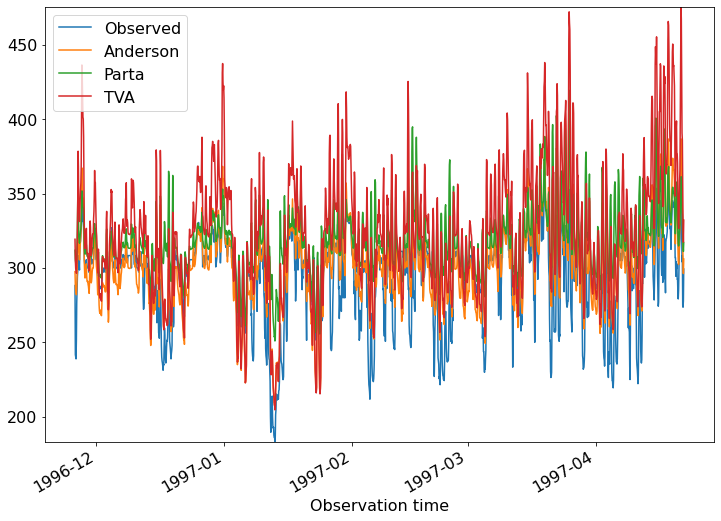

In [4]:
## the mean value for the comparsion of longwave radidation
print('Mean value for observed longwave:', force_wind['LWRadAtm'].sel(hru=1).mean().data)
print('Mean value for Anderson longwave:', lw_anderson.sel(hru=1).mean().data)
print('Mean value for Parta longwave:', lw_parta.sel(hru=1).mean().data)
print('Mean value for TVA longwave:', lw_tva.sel(hru=1).mean().data)


## the plot for the comparsion of longwave radidation
plt.figure(figsize = (12,8))
plt.rcParams.update({'font.size': 16}) 

force_wind['LWRadAtm'].sel(hru=1).plot(label='Observed')
lw_anderson.sel(hru=1).plot(label='Anderson')
lw_parta.sel(hru=1).plot(label='Parta')
lw_tva.sel(hru=1).plot(label='TVA')

ymin = min(force_wind['LWRadAtm'].sel(hru=1).min(), lw_anderson.sel(hru=1).min(), lw_parta.sel(hru=1).min(), lw_tva.sel(hru=1).min())
ymax = max(force_wind['LWRadAtm'].sel(hru=1).max(), lw_anderson.sel(hru=1).max(), lw_parta.sel(hru=1).max(), lw_tva.sel(hru=1).max())

plt.ylim((ymin, ymax))
plt.legend()

## b. 
Plot the snow water equivalent from each of your four simulations.Put all of the open (grassland, hru=0) simulations on one plot and all of the under-forest (trees, hru=1) simulations on another plot. How does the shift in snowmelt timing relate to the mean differences in longwave you reported in part a? Where (in the open or under theforest) is the simulation more sensitive to your choice of in coming longwave radiation? Why do think this is so?

In [5]:
## quick run with rescale wind speed
s.run('local', run_suffix='rescaled_wind')

## create new forcing file with Anderson longwave value
force_anderson = force_wind.copy(deep=True)
force_anderson['LWRadAtm'].values = lw_anderson.values # replace the longwave values
force_file_obs = s.force_file_list.options[0].name
force_file_anderson = force_file_wind.replace('9697_rescaled_wind', '9697_anderson')
force_anderson.to_netcdf(force_file_anderson, format='NETCDF3_CLASSIC')
s.force_file_list.options[0].name = force_file_anderson
new_force_file = str(s.force_file_list.file_name).replace('.txt', '_anderson.txt')
s.force_file_list.file_name = Path(new_force_file)
s.force_file_list.write()
fm = ps.FileManager(s.manager.original_path, s.manager.file_name)
new_filemanager_name = str(fm.file_name).replace('.txt', '_anderson.txt') 
fm['forcingListFile'] = new_force_file.split('/')[-1]
fm.file_name = Path(new_filemanager_name)
fm.path = fm.original_path
fm.write()
new_filemanager = str(fm.path / fm.file_name)
print(fm)
s_anderson = ps.Simulation(executable, new_filemanager)
s_anderson.run('local', run_suffix='lw_anderson')


controlVersion                       'SUMMA_FILE_MANAGER_V3.0.0'
simStartTime                         '1996-11-28 00:00'
simEndTime                           '1997-04-22 02:00'
tmZoneInfo                           'localTime'
settingsPath                         '/home/jovyan/data/umpqua/settings/'
forcingPath                          '/home/jovyan/data/umpqua/forcing/'
outputPath                           '/home/jovyan/data/umpqua/output/'
decisionsFile                        'snow_zDecisions.txt'
outputControlFile                    'snow_zOutputControl.txt'
globalHruParamFile                   'snow_zLocalParamInfo.txt'
globalGruParamFile                   'snow_zBasinParamInfo.txt'
attributeFile                        'snow_zLocalAttributes.nc'
trialParamFile                       'snow_zParamTrial.nc'
forcingListFile                      'snow_zForcingFileList_rescaled_wind_anderson.txt'
initConditionFile                    'snow_zInitCond.nc'
outFilePrefix                        

In [6]:
## create new forcing file with Parta longwave value
force_parta = force_wind.copy(deep=True)
force_parta['LWRadAtm'].values = lw_parta.values # replace the longwave values
force_file_parta = force_file_wind.replace('9697_rescaled_wind', '9697_parta')
force_parta.to_netcdf(force_file_parta, format='NETCDF3_CLASSIC')
s.force_file_list.options[0].name = force_file_parta
new_force_file = str(s.force_file_list.file_name).replace('_anderson.txt', '_parta.txt')
s.force_file_list.file_name = Path(new_force_file)
s.force_file_list.write()
fm = ps.FileManager(s.manager.original_path, s.manager.file_name)
new_filemanager_name = str(fm.file_name).replace('.txt', '_parta.txt') 
fm['forcingListFile'] = new_force_file.split('/')[-1]
fm.file_name = Path(new_filemanager_name)
fm.path = fm.original_path
fm.write()
new_filemanager = str(fm.path / fm.file_name)
print(fm)
s_parta = ps.Simulation(executable, new_filemanager)
s_parta.run('local', run_suffix='lw_parta')

controlVersion                       'SUMMA_FILE_MANAGER_V3.0.0'
simStartTime                         '1996-11-28 00:00'
simEndTime                           '1997-04-22 02:00'
tmZoneInfo                           'localTime'
settingsPath                         '/home/jovyan/data/umpqua/settings/'
forcingPath                          '/home/jovyan/data/umpqua/forcing/'
outputPath                           '/home/jovyan/data/umpqua/output/'
decisionsFile                        'snow_zDecisions.txt'
outputControlFile                    'snow_zOutputControl.txt'
globalHruParamFile                   'snow_zLocalParamInfo.txt'
globalGruParamFile                   'snow_zBasinParamInfo.txt'
attributeFile                        'snow_zLocalAttributes.nc'
trialParamFile                       'snow_zParamTrial.nc'
forcingListFile                      'snow_zForcingFileList_rescaled_wind_parta.txt'
initConditionFile                    'snow_zInitCond.nc'
outFilePrefix                        'um

In [7]:
## create new forcing file with TVA longwave value
force_tva = force_wind.copy(deep=True)
force_tva['LWRadAtm'].values = lw_tva.values # replace the longwave values
force_file_tva= force_file_wind.replace('9697_rescaled_wind', '9697_tva')
force_tva.to_netcdf(force_file_tva, format='NETCDF3_CLASSIC')
s.force_file_list.options[0].name = force_file_tva
new_force_file = str(s.force_file_list.file_name).replace('_parta.txt', '_tva.txt')
s.force_file_list.file_name = Path(new_force_file)
s.force_file_list.write()
fm = ps.FileManager(s.manager.original_path, s.manager.file_name)
new_filemanager_name = str(fm.file_name).replace('.txt', '_tva.txt') 
fm['forcingListFile'] = new_force_file.split('/')[-1]
fm.file_name = Path(new_filemanager_name)
fm.path = fm.original_path
fm.write()
new_filemanager = str(fm.path / fm.file_name)
print(fm)
s_tva = ps.Simulation(executable, new_filemanager)
s_tva.run('local', run_suffix='lw_tva')

controlVersion                       'SUMMA_FILE_MANAGER_V3.0.0'
simStartTime                         '1996-11-28 00:00'
simEndTime                           '1997-04-22 02:00'
tmZoneInfo                           'localTime'
settingsPath                         '/home/jovyan/data/umpqua/settings/'
forcingPath                          '/home/jovyan/data/umpqua/forcing/'
outputPath                           '/home/jovyan/data/umpqua/output/'
decisionsFile                        'snow_zDecisions.txt'
outputControlFile                    'snow_zOutputControl.txt'
globalHruParamFile                   'snow_zLocalParamInfo.txt'
globalGruParamFile                   'snow_zBasinParamInfo.txt'
attributeFile                        'snow_zLocalAttributes.nc'
trialParamFile                       'snow_zParamTrial.nc'
forcingListFile                      'snow_zForcingFileList_rescaled_wind_tva.txt'
initConditionFile                    'snow_zInitCond.nc'
outFilePrefix                        'umpq

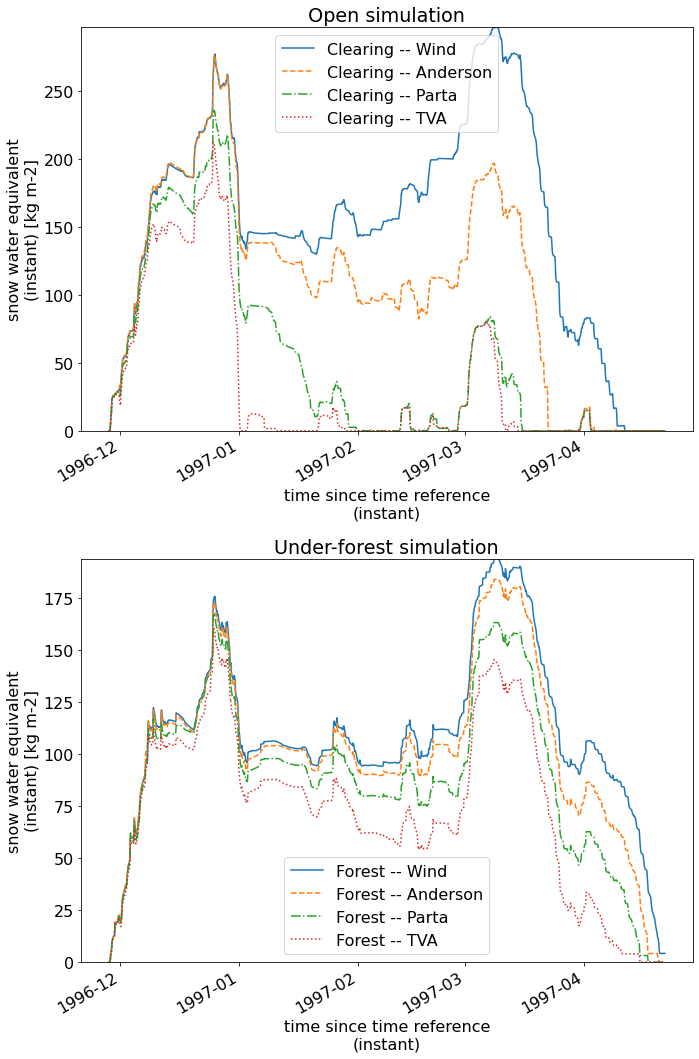

In [8]:
plt.figure(figsize=[10,15],tight_layout=True)
plt.rcParams.update({'font.size': 16}) 
plt.subplot(2,1,1)
s.output['scalarSWE'].isel(hru=0).plot(label='Clearing -- Wind', 
                                            color=cycle[0], linestyle='-')

s_anderson.output['scalarSWE'].isel(hru=0).plot(label='Clearing -- Anderson',
                                        color=cycle[1], linestyle='--')

s_parta.output['scalarSWE'].isel(hru=0).plot(label='Clearing -- Parta',
                                        color=cycle[2], linestyle='-.')

s_tva.output['scalarSWE'].isel(hru=0).plot(label='Clearing -- TVA',
                                        color=cycle[3], linestyle=':')
plt.title('Open simulation')

max_swe = max(s.output['scalarSWE'].isel(hru=0).max(), s_anderson.output['scalarSWE'].isel(hru=0).max(),
              s_parta.output['scalarSWE'].isel(hru=0).max(), s_tva.output['scalarSWE'].isel(hru=0).max())
plt.ylim(0,max_swe)
plt.legend()

plt.subplot(2,1,2)
s.output['scalarSWE'].isel(hru=1).plot(label='Forest -- Wind',
                                            color=cycle[0], linestyle='-')

s_anderson.output['scalarSWE'].isel(hru=1).plot(label='Forest -- Anderson',
                                        color=cycle[1], linestyle='--')

s_parta.output['scalarSWE'].isel(hru=1).plot(label='Forest -- Parta',
                                        color=cycle[2], linestyle='-.')

s_tva.output['scalarSWE'].isel(hru=1).plot(label='Forest -- TVA',
                                        color=cycle[3], linestyle=':')
plt.title('Under-forest simulation')

max_swe = max(s.output['scalarSWE'].isel(hru=1).max(), s_anderson.output['scalarSWE'].isel(hru=1).max(),
              s_parta.output['scalarSWE'].isel(hru=1).max(), s_tva.output['scalarSWE'].isel(hru=1).max())

plt.ylim(0,max_swe)
plt.legend()

## c. 
Plot the snow surface layer temperature for each of your four simulations, again, with separate plots for the open and forest sites. How does snow surface temperature vary as a function of incoming longwave radiation? Which, snow surface temperature or snow water equivalent, do you think is a better metric to consider at this particular site for evaluating the best choice of incoming longwave radiation? Why?

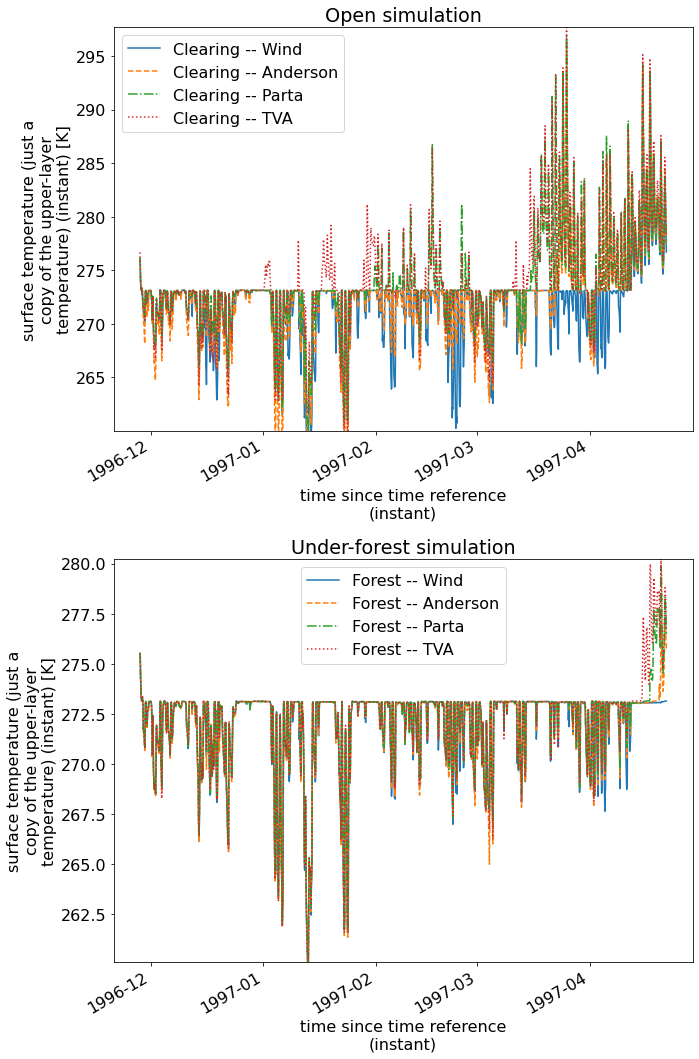

In [9]:

plt.figure(figsize=[10,15],tight_layout=True)
plt.rcParams.update({'font.size': 16}) 
plt.subplot(2,1,1)
s.output['scalarSurfaceTemp'].isel(hru=0).plot(label='Clearing -- Wind', 
                                            color=cycle[0], linestyle='-')

s_anderson.output['scalarSurfaceTemp'].isel(hru=0).plot(label='Clearing -- Anderson',
                                        color=cycle[1], linestyle='--')

s_parta.output['scalarSurfaceTemp'].isel(hru=0).plot(label='Clearing -- Parta',
                                        color=cycle[2], linestyle='-.')

s_tva.output['scalarSurfaceTemp'].isel(hru=0).plot(label='Clearing -- TVA',
                                        color=cycle[3], linestyle=':')
plt.title('Open simulation')

max_t = max(s.output['scalarSurfaceTemp'].isel(hru=0).max(), s_anderson.output['scalarSurfaceTemp'].isel(hru=0).max(),
              s_parta.output['scalarSurfaceTemp'].isel(hru=0).max(), s_tva.output['scalarSurfaceTemp'].isel(hru=0).max())
min_t = max(s.output['scalarSurfaceTemp'].isel(hru=0).min(), s_anderson.output['scalarSurfaceTemp'].isel(hru=0).min(),
              s_parta.output['scalarSurfaceTemp'].isel(hru=0).min(), s_tva.output['scalarSurfaceTemp'].isel(hru=0).min())

plt.ylim(min_t,max_t)
plt.legend()

plt.subplot(2,1,2)
s.output['scalarSurfaceTemp'].isel(hru=1).plot(label='Forest -- Wind',
                                            color=cycle[0], linestyle='-')

s_anderson.output['scalarSurfaceTemp'].isel(hru=1).plot(label='Forest -- Anderson',
                                        color=cycle[1], linestyle='--')

s_parta.output['scalarSurfaceTemp'].isel(hru=1).plot(label='Forest -- Parta',
                                        color=cycle[2], linestyle='-.')

s_tva.output['scalarSurfaceTemp'].isel(hru=1).plot(label='Forest -- TVA',
                                        color=cycle[3], linestyle=':')
plt.title('Under-forest simulation')

max_t = max(s.output['scalarSurfaceTemp'].isel(hru=1).max(), s_anderson.output['scalarSurfaceTemp'].isel(hru=1).max(),
              s_parta.output['scalarSurfaceTemp'].isel(hru=1).max(), s_tva.output['scalarSurfaceTemp'].isel(hru=1).max())
min_t = max(s.output['scalarSurfaceTemp'].isel(hru=1).min(), s_anderson.output['scalarSurfaceTemp'].isel(hru=1).min(),
              s_parta.output['scalarSurfaceTemp'].isel(hru=1).min(), s_tva.output['scalarSurfaceTemp'].isel(hru=1).min())

plt.ylim(min_t,max_t)
plt.legend()

## d. 
In class we discussed the location of this site (a maritime forest in Oregon, close to Crater Lake National Park). Winter temperatures are close to 0°C. What about this site makes it especially sensitive to incoming longwave radiation? How transferable do you think that your results from this experiment are to other locations? What might you expect to be different at a colder, more continental site?

See attached pdf file

## 2. 
At this point, you should start thinking about partners for your final presentation and an idea what you want to present. You will need to turn ina proposal for the final presentation with your next assignment. For now,homework_1_E_exercise_3.ipynb provides many options that you may want to explore for your final project, so take a look at it and talk to others in theclass. (Slack might work well for this discussion.) For this homework, just write down any questions you have or plans you’re thinking about at thispoint (they don’t need to be final yet).

See attached pdf file